In [190]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pandas as pd
import random

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

In [191]:
path = "/Users/muhammadhussain/Desktop/DEEPLEARNINGPROJECT/Data/cleaned_data_806016.parquet"
df = pd.read_parquet(path)
data = df.to_numpy()

In [192]:
evaldatatrain = df
evaldatatrain["target"] = [int(random.randint(0, 9)) for i in range(len(evaldatatrain))]
evaldatatrain

,Datetime,RTD,1st Suc.,Cond. Air In,Evap. In,Evap. Out,2nd Suc.,Chil. water In,2nd Sump,H.E.,SetPoint,Mains Voltage,State,Type,Event,target
0,2012-08-22 19:51:26,-70.0,-33.0,19.3,-83.0,-77.6,-44.8,23.1,48.8,-34.0,-80,227.0,3,None,None,6
1,2012-08-22 19:52:26,-71.3,-33.0,19.2,-83.0,-80.4,-45.7,22.7,48.7,-34.0,-80,227.0,3,None,None,9
2,2012-08-22 19:53:26,-72.4,-33.0,19.3,-83.0,-84.2,-46.8,22.8,48.6,-34.0,-80,228.0,3,None,None,5
3,2012-08-22 19:54:26,-73.1,-33.2,19.3,-83.0,-86.1,-48.0,22.5,48.5,-34.0,-80,228.0,3,None,None,4
4,2012-08-22 19:55:26,-74.0,-33.8,19.3,-83.0,-87.0,-49.1,22.4,48.4,-34.0,-80,228.0,3,None,None,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923219,2023-04-01 00:54:26,-80.1,-36.2,19.4,-84.3,-89.2,-54.5,26.0,28.8,-32.9,-80,224.5,3,None,None,5
2923220,2023-04-01 00:55:26,-80.2,-36.2,19.0,-84.4,-89.2,-54.6,25.5,28.9,-33.0,-80,225.4,3,None,None,4
2923221,2023-04-01 00:56:26,-80.2,-36.2,18.9,-84.4,-89.1,-54.6,25.6,28.9,-32.9,-80,225.4,3,None,None,9
2923222,2023-04-01 00:57:26,-80.3,-36.2,18.9,-84.4,-89.3,-54.7,26.2,28.9,-33.1,-80,224.9,3,None,None,2


In [193]:
inp = evaldatatrain.drop(columns=["target", "Datetime", "Type", "Event"])
time = evaldatatrain["Datetime"]
out = evaldatatrain["target"]

In [194]:
inp = torch.tensor(inp.values, dtype=torch.float32)
out = torch.tensor(out.values, dtype=torch.int32)

In [195]:
out

tensor([6, 9, 5,  ..., 9, 2, 6], dtype=torch.int32)

In [196]:
round(len(inp)/3)

974408

In [197]:
# To speed up training we'll only work on a subset of the data
#x_train = inp[:round(len(inp)/3)]
#targets_train = out[:round(len(inp)/3)]

#x_valid = inp[round(len(inp)/3):round(2*len(inp)/3)]
#targets_valid = out[round(len(inp)/3):round(2*len(inp)/3)]

#x_test = inp[round(2*len(inp)/3):]
#targets_test = out[round(2*len(inp)/3):]

x_train = inp[:1000]
targets_train = out[:1000]

x_valid = inp[1000:2000]
targets_valid = out[1000:2000]

x_test = inp[2000:3000]
targets_test = out[2000:3000]


print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train torch.Size([1000, 12])
targets_train torch.Size([1000])
x_valid torch.Size([1000, 12])
targets_valid torch.Size([1000])
x_test torch.Size([1000, 12])
targets_test torch.Size([1000])


In [198]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # batchNorm
        self.norm1 = nn.BatchNorm1d(num_features=num_hidden)
        # dropout layer
        self.dropout = nn.Dropout(0.2)
        # hidden layer 1
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_hidden, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer 2
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_output, num_hidden)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.dropout(x)

        x = F.linear(x, self.W_1, self.b_1)
        x = self.norm1(x)
        x = self.activation(x)

        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = F.linear(x, self.W_3, self.b_3)

        return x


net = Net(num_features, num_l1, num_classes)

In [199]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

In [200]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, 12)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


In [201]:
net(torch.from_numpy(np.random.normal(0, 1, (4, 12)).astype('float32')))

tensor([[ 0.6164, -0.1948,  0.2103,  1.1434, -0.2069,  1.0179,  0.1416,  2.8032,
          0.4818, -1.6700],
        [ 1.6183,  1.4398, -0.9844,  0.8309,  0.7220, -0.9425,  0.0156,  2.0015,
         -1.0306, -0.1388],
        [-0.0871,  2.4764,  0.8730,  1.0274, -1.5435,  0.5462,  0.1050,  0.8656,
         -1.3926,  1.0454],
        [ 1.0892,  0.4456, -0.4799,  0.2913, -1.1441,  1.7665,  0.4208,  1.6753,
          0.7315, -0.3674]], grad_fn=<AddmmBackward0>)

In [202]:
targets_train

tensor([6, 9, 5, 4, 8, 6, 4, 7, 1, 4, 6, 2, 1, 1, 4, 2, 5, 3, 3, 4, 3, 9, 1, 4,
        7, 5, 8, 4, 1, 2, 1, 7, 4, 2, 4, 2, 7, 6, 5, 5, 9, 7, 7, 3, 4, 3, 3, 8,
        8, 0, 3, 6, 5, 3, 5, 9, 1, 3, 0, 9, 9, 5, 1, 1, 1, 4, 9, 5, 0, 5, 7, 9,
        8, 8, 9, 5, 0, 9, 3, 6, 6, 3, 4, 4, 2, 2, 5, 8, 0, 3, 8, 2, 2, 0, 7, 8,
        6, 6, 8, 3, 2, 9, 3, 9, 9, 1, 1, 8, 7, 8, 8, 3, 9, 5, 2, 7, 7, 3, 8, 5,
        9, 4, 0, 4, 0, 2, 3, 7, 9, 8, 4, 9, 3, 6, 4, 4, 7, 2, 9, 7, 0, 4, 6, 8,
        4, 9, 2, 8, 4, 2, 1, 0, 8, 6, 1, 3, 6, 2, 2, 3, 3, 9, 0, 1, 9, 3, 6, 4,
        2, 6, 9, 7, 7, 7, 0, 5, 3, 2, 0, 5, 6, 6, 7, 9, 0, 0, 9, 9, 7, 5, 4, 4,
        3, 4, 7, 8, 2, 7, 1, 5, 9, 7, 5, 2, 9, 2, 1, 7, 0, 2, 2, 1, 3, 9, 3, 9,
        2, 6, 3, 1, 8, 2, 5, 6, 6, 3, 8, 5, 1, 7, 7, 0, 8, 4, 9, 9, 2, 3, 1, 0,
        8, 5, 0, 1, 4, 5, 2, 8, 5, 7, 8, 9, 0, 2, 3, 3, 2, 7, 5, 0, 0, 1, 2, 2,
        0, 5, 7, 9, 2, 5, 2, 4, 8, 7, 8, 6, 1, 0, 3, 5, 3, 9, 2, 2, 5, 4, 0, 7,
        0, 4, 8, 6, 5, 5, 1, 1, 6, 1, 1,

In [203]:
targets_train = targets_train.long()
targets_train

tensor([6, 9, 5, 4, 8, 6, 4, 7, 1, 4, 6, 2, 1, 1, 4, 2, 5, 3, 3, 4, 3, 9, 1, 4,
        7, 5, 8, 4, 1, 2, 1, 7, 4, 2, 4, 2, 7, 6, 5, 5, 9, 7, 7, 3, 4, 3, 3, 8,
        8, 0, 3, 6, 5, 3, 5, 9, 1, 3, 0, 9, 9, 5, 1, 1, 1, 4, 9, 5, 0, 5, 7, 9,
        8, 8, 9, 5, 0, 9, 3, 6, 6, 3, 4, 4, 2, 2, 5, 8, 0, 3, 8, 2, 2, 0, 7, 8,
        6, 6, 8, 3, 2, 9, 3, 9, 9, 1, 1, 8, 7, 8, 8, 3, 9, 5, 2, 7, 7, 3, 8, 5,
        9, 4, 0, 4, 0, 2, 3, 7, 9, 8, 4, 9, 3, 6, 4, 4, 7, 2, 9, 7, 0, 4, 6, 8,
        4, 9, 2, 8, 4, 2, 1, 0, 8, 6, 1, 3, 6, 2, 2, 3, 3, 9, 0, 1, 9, 3, 6, 4,
        2, 6, 9, 7, 7, 7, 0, 5, 3, 2, 0, 5, 6, 6, 7, 9, 0, 0, 9, 9, 7, 5, 4, 4,
        3, 4, 7, 8, 2, 7, 1, 5, 9, 7, 5, 2, 9, 2, 1, 7, 0, 2, 2, 1, 3, 9, 3, 9,
        2, 6, 3, 1, 8, 2, 5, 6, 6, 3, 8, 5, 1, 7, 7, 0, 8, 4, 9, 9, 2, 3, 1, 0,
        8, 5, 0, 1, 4, 5, 2, 8, 5, 7, 8, 9, 0, 2, 3, 3, 2, 7, 5, 0, 0, 1, 2, 2,
        0, 5, 7, 9, 2, 5, 2, 4, 8, 7, 8, 6, 1, 0, 3, 5, 3, 9, 2, 2, 5, 4, 0, 7,
        0, 4, 8, 6, 5, 5, 1, 1, 6, 1, 1,

Epoch  1 : Train Loss 0.508257 , Train acc 0.101000, Valid acc 0.099000
Epoch 11 : Train Loss 0.232034 , Train acc 0.116000, Valid acc 0.110000
Epoch 21 : Train Loss 0.229929 , Train acc 0.116000, Valid acc 0.110000
Epoch 31 : Train Loss 0.229959 , Train acc 0.116000, Valid acc 0.110000
Epoch 41 : Train Loss 0.229959 , Train acc 0.116000, Valid acc 0.110000
Epoch 51 : Train Loss 0.229959 , Train acc 0.116000, Valid acc 0.110000
Epoch 61 : Train Loss 0.229958 , Train acc 0.116000, Valid acc 0.110000
Epoch 71 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 81 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 91 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 101 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 111 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 121 : Train Loss 0.229957 , Train acc 0.116000, Valid acc 0.110000
Epoch 131 : Train Loss 0.229957 , Train acc 0.116000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

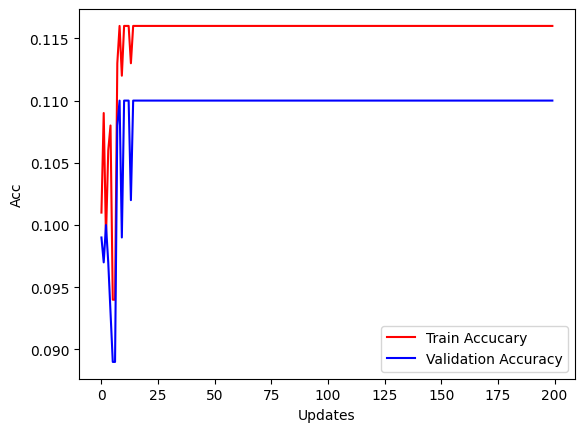

In [204]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [205]:
net.eval()

Net(
  (norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)

In [206]:
output = net(x_test[100].unsqueeze(0))
output

tensor([[-0.0144,  0.1411, -0.0062,  0.0452, -0.0936, -0.0543, -0.0526, -0.0264,
         -0.0550,  0.1138]], grad_fn=<AddmmBackward0>)

In [207]:
predictedclass = torch.argmax(output, dim=1)
predictedclass

tensor([1])

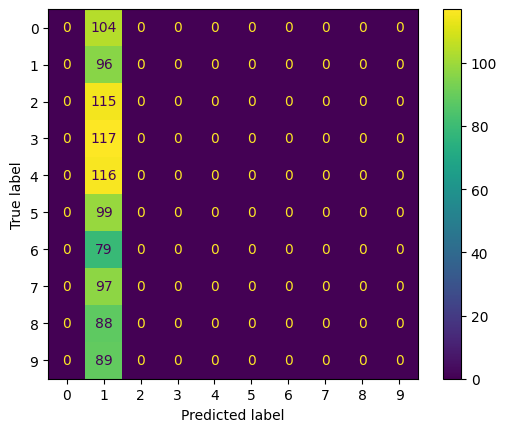

In [208]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


predictedclass = torch.argmax(net(x_test), dim=1)

cm = confusion_matrix(targets_test, predictedclass)
ConfusionMatrixDisplay(cm).plot()

In [212]:
binarypredictedclass = [1 if i > 0 else 0 for i in predictedclass]
binarytargets_test = [1 if i > 0 else 0 for i in targets_test]

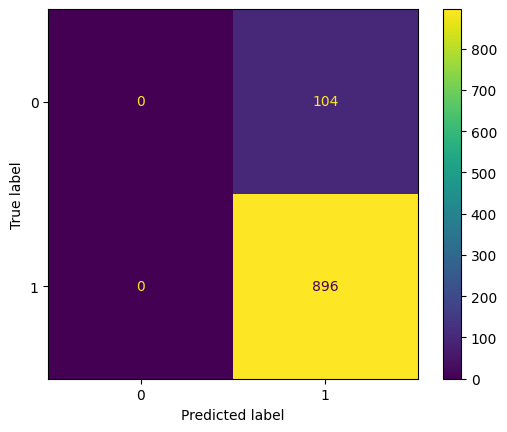

In [210]:
cm = confusion_matrix(binarytargets_test, binarypredictedclass)
ConfusionMatrixDisplay(cm).plot()

In [211]:
unique_values, counts = torch.unique(targets_train, return_counts=True)

print("Unikke værdier:", unique_values)
print("Hyppigheder:", counts)

Unikke værdier: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Hyppigheder: tensor([ 98, 116,  99, 105,  90,  94,  94,  97,  94, 113])
